<a href="https://colab.research.google.com/github/zhlu97/pn_pc_cls/blob/master/EasyPointNet_Plot_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Easiest PointNet Possible

## Fetch ModelNet40 and Decompress

In [ ]:
!wget https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip

--2020-04-23 19:49:58--  https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1705117335 (1.6G) [application/zip]
Saving to: ‘modelnet40_normal_resampled.zip.1’

lnet40_normal_resam  10%[=>                  ] 166.95M  8.44MB/s    eta 2m 39s ^C


In [ ]:
%%capture
!unzip modelnet40_normal_resampled.zip

MessageError: ignored

## Import Libraries

In [ ]:
import numpy as np
import warnings
import os
from torch.utils.data import Dataset
warnings.filterwarnings('ignore')

import torch
import logging
# from tqdm import tqdm
from tqdm.notebook import tqdm
import sys
import importlib

import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable

import torch.nn.functional as F
import matplotlib.pyplot as plt

## Define hyperparameters

In [ ]:
batch_size = 60
sample_point_count = 1024
num_classes = 40
num_epoch = 20
learning_rate = 0.001
rootPath = '/content/modelnet40_normal_resampled/'
# rootPath = '/home/isuzu/modelnet40_normal_resampled/'

## Dataloader

### To use Pytorch's built-in dataloader, must implement subclass and override all three functions below.

In [ ]:
def farthest_point_sample(point, npoint):
    """
    Input:
        xyz: pointcloud data, [N, D]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [npoint, D]
    """
    N, D = point.shape
    xyz = point[:,:3]
    centroids = np.zeros((npoint,))
    distance = np.ones((N,)) * 1e10
    farthest = np.random.randint(0, N)
    for i in range(npoint):
        centroids[i] = farthest
        centroid = xyz[farthest, :]
        dist = np.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = np.argmax(distance, -1)
    point = point[centroids.astype(np.int32)]
    return point
    
class ModelNetResampledLoader(Dataset):
  def __init__(self, rootPath, mode):
        self.categoryNames = [line.rstrip() for line in open(os.path.join(rootPath, 'modelnet40_shape_names.txt'))]
        self.classes = dict(zip(self.categoryNames, range(len(self.categoryNames))))

        self.all_IDs = {}
        self.all_IDs['train'] = [line.rstrip() for line in open(os.path.join(rootPath, 'modelnet40_train.txt'))]
        self.all_IDs['test']  = [line.rstrip() for line in open(os.path.join(rootPath, 'modelnet40_test.txt'))]   

        shape_names = ['_'.join(x.split('_')[0:-1]) for x in self.all_IDs[mode]]
        self.datapath = [(shape_names[i], os.path.join(rootPath, shape_names[i], self.all_IDs[mode][i]) + '.txt') for i
                         in range(len(self.all_IDs[mode]))]        

  def __len__(self):
        'Denotes the total number of samples'
        'num of .txt'
        return len(self.datapath)

  def __getitem__(self, index):
        selectedDatapaths = self.datapath[index]
        selectedClasses   = self.classes[selectedDatapaths[0]]
        selectedClasses   = np.array([selectedClasses]).astype(np.int32)

        pointSet = np.loadtxt(selectedDatapaths[1], delimiter=',').astype(np.float32)
        # pointSet = pointSet[0:sample_point_count,:] #Only choosing first 1024? -- Points have no ordering. We can already see shape with first 1024 pts
        pointSet = farthest_point_sample(pointSet, sample_point_count)
        pointSet = pointSet[:, 0:3]
        plt.plot(pointSet)

        return pointSet, selectedClasses

## Simpliest PointNet Model

In [ ]:
class STNkd(torch.nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, k * k)
        self.relu = torch.nn.ReLU()

        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.bn5 = torch.nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class TNet(torch.nn.Module):
    def __init__(self, channel=3):
        super(TNet, self).__init__()
        self.channel = channel
        self.affine = torch.nn.Linear(channel, channel)

    def forward(self, x):
        print(torch.transpose(x, 2, 1))
        return self.affine(torch.transpose(x, 2, 1))

class PointNetEncoder(torch.nn.Module):
    def __init__(self, channel=3):
        super(PointNetEncoder, self).__init__()

        # self.tNet3 = TNet(channel)
        self.tNet3 = STNkd(channel)
        self.featureExpansion_3_64 = torch.nn.Sequential(
            torch.nn.Conv1d(channel, 64, 1),
            torch.nn.BatchNorm1d(64)
        )
        # self.tNet64 = TNet(64)
        self.tNet64 = STNkd(64)
        self.featureExpansion_64_128_1024 = torch.nn.Sequential(
            torch.nn.Conv1d(64, 64, 1),
            torch.nn.BatchNorm1d(64),
            torch.nn.Conv1d(64, 128, 1),
            torch.nn.BatchNorm1d(128),
            torch.nn.Conv1d(128, 1024, 1),
            torch.nn.BatchNorm1d(1024)
        )

    def forward(self, x):
        B, D, N = x.size()

        inputTransform = self.tNet3(x)
        
        x = x.transpose(2, 1)
        x = torch.bmm(x, inputTransform)
        x = x.transpose(2, 1)

        x = self.featureExpansion_3_64(x)
        featTranform = self.tNet64(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, featTranform)
        x = x.transpose(2, 1)

        pointfeat = x
        x = self.featureExpansion_64_128_1024(x)
        x, max_indices = torch.max(x, 2, keepdim=True)
        # x = torch.max(x, 2, keepdim=True)
        x = x.view(-1, 1024)

        return x, inputTransform, featTranform, max_indices
        # return x, inputTransform, featTranform

class get_model(torch.nn.Module):
    def __init__(self, channel = 3):
        super(get_model, self).__init__()

        self.pointNetEncoder = PointNetEncoder(channel=channel)

        self.pointNetDecoder = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.Dropout(p=0.4),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes),
            torch.nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x, inputTransform, featTranform, max_indices = self.pointNetEncoder(x)
        # x, inputTransform, featTranform = self.pointNetEncoder(x)
        x = self.pointNetDecoder(x)
        return x, max_indices
        # return x

class get_loss(torch.nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()

    def forward(self, pred, target):
        loss = torch.nn.functional.nll_loss(pred, target)
        return loss

## Training

In [ ]:
# Get data loader
trainData = ModelNetResampledLoader(rootPath=rootPath, mode='train')
testData  = ModelNetResampledLoader(rootPath=rootPath, mode='test')
trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=4)
testDataLoader  = torch.utils.data.DataLoader(testData, batch_size=batch_size, shuffle=False, num_workers=4)

# Get model
model = Model().cuda()
criterion = Loss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

FileNotFoundError: ignored

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
print('Start training... Batch size： %d' % batch_size)
for epoch in range(0,num_epoch):
    correctRates = []
    for batch_id, data in tqdm(enumerate(trainDataLoader, 0), total=len(trainDataLoader)):
        points, target = data

        # # print("points info")
        # # print(points)
        # print(points.shape)
        # # print("target info")
        # # print(target)
        # print(target.shape)
        # x, y, z = points[5, :, 0], points[5, :, 1], points[5, :, 2]
        # ax = plt.subplot(111, projection='3d')  # 3d plot
        # ax.scatter(x[:], y[:], z[:], c='y')
        # # ax.scatter(x[10:20], y[10:20], z[10:20], c='r')
        # # ax.scatter(x[30:40], y[30:40], z[30:40], c='g')
        # ax.set_zlabel('Z') 
        # ax.set_ylabel('Y')
        # ax.set_xlabel('X')
        # plt.show()
        # print(target[5, 0])

        points = points.data.numpy()
        points = torch.Tensor(points)
        target = target[:, 0]

        points = points.transpose(2, 1)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()

        model = model.train()
        pred, max_indices = model(points)

        # print('type(pred): ', type(pred))
        # print('pred.shape: ', pred.shape)
        # print('type(points): ', type(points))
        # print('points.shape: ', points.shape)
        # print('type(max_indices): ', type(max_indices))
        # print('max_indices.shape: ', max_indices.shape)
        # # print(max_indices)
        max_indices = max_indices.view(-1, 1024)
        # max_indices = max_indices.numpy()
        # print(max_indices.shape)
        # fifth_max_indices = max_indices[5, :, :].reshape(1024)
        # print("fifth_max_indices", fifth_max_indices.shape)
        # fifth_max_indices = fifth_max_indices[0]
        # print("fifth_max_indices[0]", fifth_max_indices.shape)
        x = points[5, max_indices[5], :]
        # x, y, z = points[5, max_indices[5, :, 0], :], points[5, max_indices[5, :, :], 1], points[5, max_indices[5, :, :], 2]
        # ax = plt.subplot(111, projection='3d')
        # ax.scatter(x[:], y[:], z[:], c='r')
        # plt.show()

        loss = criterion(pred, target.long())
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.long().data).cpu().sum()
        correctRates.append(correct.item() / float(points.size()[0]))
        loss.backward()
        optimizer.step()

    trainEpochAccuracy = np.mean(correctRates)
    print('Train Epoch %d Accuracy: %f' %(epoch, trainEpochAccuracy))

torch.save(model, 'model.pytorch')

Start training... Batch size： 60


## Testing

In [ ]:
# Model class must be defined somewhere
model = torch.load('model.pytorch')
model.eval()

mean_correct = []
class_acc = np.zeros((num_classes,3))

torch.load('/content/modelnet40_normal_resampled/chair/chair_0001.txt')


for batch_id, data in tqdm(enumerate(testDataLoader), total=len(testDataLoader)):
    points, target = data
    target = target[:, 0]
    points = points.transpose(2, 1)
    points, target = points.cuda(), target.cuda()
    classifier = model.eval()
    pred = classifier(points)
    pred_choice = pred.data.max(1)[1].type(torch.cuda.IntTensor)
    equalCount = (pred_choice == target).cpu().sum()
    mean_correct.append(equalCount.item() / float(points.size()[0]))
instance_acc = np.mean(mean_correct)
print('Test Instance Accuracy: %f' % instance_acc)

FileNotFoundError: ignored

In [ ]:
p = torch.tensor([[[2, 3, 5], [6, 1 ,0],[6, 1 ,10],[100,0,-1]], 
                  [[6, 1 ,0], [2, 3, 5],[6, 1 ,10], [100,0,-2]], 
                  [[6, 1 ,0], [2, 3, 5],[6, 1 ,10], [100,0,-2]], 
                  [[6, 1 ,0], [2, 3, 5],[6, 1 ,10], [100,0,-2]], 
                  [[6, 1 ,0], [2, 3, 5],[6, 1 ,10], [100,0,-2]]]).cuda()
x, max_idx = torch.max(p, 1, keepdim=True)
max_idx = max_idx.view(-1, 3)
# print('type(p): ', type(p))
# print('p.shape: ', p.shape)
print(max_idx)
y = p[1,max_idx[1],:]
print(y)

tensor([[3, 0, 2],
        [3, 1, 2],
        [3, 1, 2],
        [3, 1, 2],
        [3, 1, 2]], device='cuda:0')
tensor([[100,   0,  -2],
        [  2,   3,   5],
        [  6,   1,  10]], device='cuda:0')


tensor([[[-0.3495,  0.0416,  0.4857,  ...,  0.3495, -0.3744,  0.4410],
         [ 0.1553,  0.1553,  0.0547,  ...,  0.1553,  0.3328, -0.2581],
         [ 0.0137,  0.1469,  0.4324,  ..., -0.2359,  0.4469, -0.3695]]],
       device='cuda:0')
(1, 3, 1024)


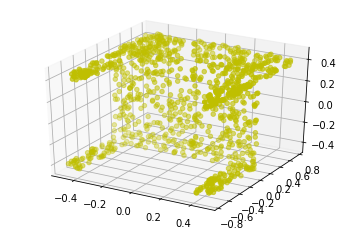

In [ ]:
# Model class must be defined somewhere
# model = torch.load('model.pytorch')
# model.eval()

from numpy import genfromtxt
testPoints = genfromtxt('/content/modelnet40_normal_resampled/chair/chair_0009.txt',delimiter=',')
testPoints = testPoints[8000:9024, 0:3]
# testPoints = testPoints[0:1024, 0:3]

# testPoints = farthest_point_sample(testPoints, sample_point_count)
# # print("shape of testPoints", testPoints.shape)
# testPoints = testPoints[:, 0:3]
testPoints = torch.tensor(testPoints).cuda()

testPoints = torch.transpose(testPoints, 0, 1)
testPoints = testPoints.view(-1, 3, 1024)
testPoints = testPoints.float()

# pred, max_indices = model(testPoints)
print(testPoints)
testPoints = testPoints.cpu().numpy()
print(testPoints.shape)
x, y, z = testPoints[:, 0, :], testPoints[:, 1, :], testPoints[:, 2, :]
ax = plt.subplot(111, projection='3d')  # 3d plot
ax.scatter(x[:], y[:], z[:], c='y')

# y = testPoints[0, max_indices[0], :]
# ax = plt.subplot(111, projection='3d')
# ax.scatter(x[:], y[:], z[:], c='r')
# max_indices = max_indices.cpu().numpy()

# x, y, z = testPoints[0, 0, max_indices[0]], testPoints[0, 1, max_indices[0]], testPoints[0, 2,max_indices[0]]
# ax = plt.subplot(111, projection='3d')
# ax.scatter(x[:], y[:], z[:], c='r')
# plt.show()
# print(max_indices.shape)
# print(max_indices)
# points, target = data
# target = target[:, 0]
# points = points.transpose(2, 1)
# points, target = points.cuda(), target.cuda()
# classifier = model.eval()
# pred = classifier(points)
# pred_choice = pred.data.max(1)[1].type(torch.cuda.IntTensor)
# equalCount = (pred_choice == target).cpu().sum()
# mean_correct.append(equalCount.item() / float(points.size()[0]))